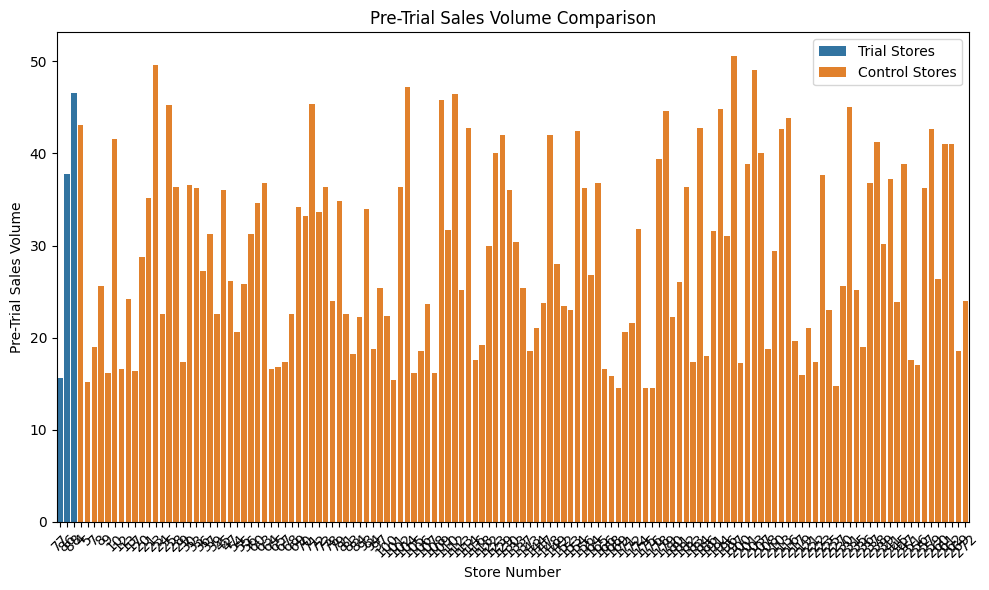

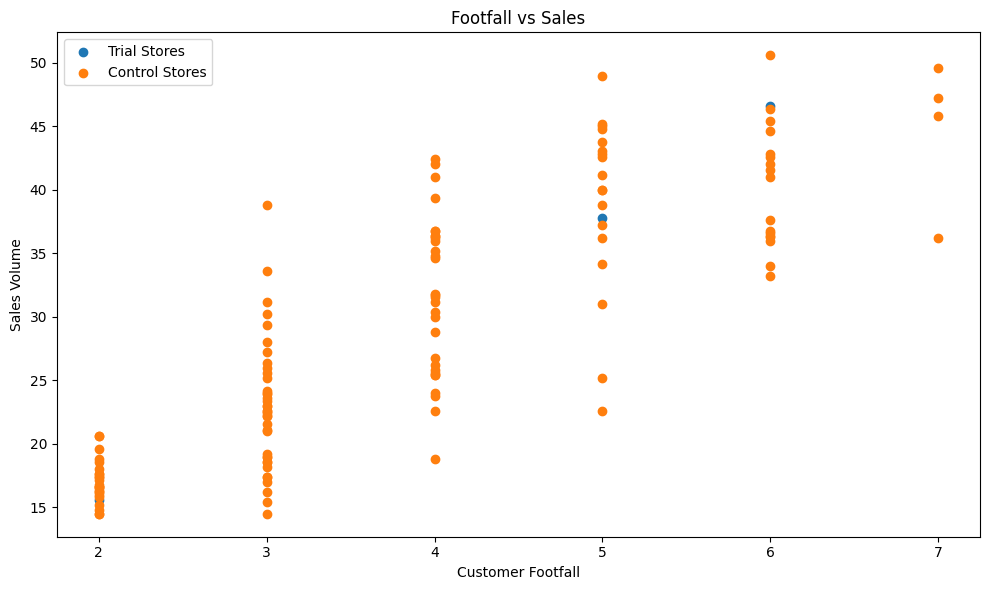

In [21]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'QVI_data.csv' is uploaded and accessible

data = pd.read_csv('QVI_data.csv')

# Preprocessing (example - adapt based on your actual data columns)
# Assuming 'STORE_NBR', 'TOT_SALES', 'LYLTY_CARD_NBR' (for footfall proxy), 'PROD_QTY' are relevant
#  and you have a 'DATE' column to filter the pre-trial period

# Define the trial period start and end dates (replace with your actual dates)
trial_start_date = pd.to_datetime('2018-07-01')  # Example
trial_end_date = pd.to_datetime('2019-06-30')    # Example

# Filter data for pre-trial period
data['DATE'] = pd.to_datetime(data['DATE'])  # Convert 'DATE' to datetime if not already done
pre_trial_data = data[data['DATE'] < trial_start_date]

# Check if pre_trial_data is empty and adjust trial_start_date if necessary
if pre_trial_data.empty:
    # Find the minimum date in the dataset to ensure pre_trial_data is not empty
    min_date = data['DATE'].min()
    trial_start_date = min_date + pd.DateOffset(days=1)  # Set trial_start_date to one day after the minimum date
    pre_trial_data = data[data['DATE'] < trial_start_date]  # Re-filter the data


# Group data by store
store_metrics = pre_trial_data.groupby('STORE_NBR').agg(
    sales_volume=('TOT_SALES', 'sum'),  # Total sales
    customer_footfall=('LYLTY_CARD_NBR', 'nunique'),  # Unique loyalty card holders as footfall proxy
    product_range=('PROD_QTY', 'nunique') #Variety of chips
)

# Identify trial stores (replace with your actual trial store numbers)
trial_stores = [77, 86, 88] # Example
trial_data = store_metrics.loc[trial_stores]


# Identify potential control stores
potential_control_stores = store_metrics.drop(index=trial_stores)

# Matching based on sales volume (Example using a simple threshold, explore more sophisticated methods)
sales_threshold = 0.1  # 10% difference allowed
control_stores = potential_control_stores[
    (potential_control_stores['sales_volume'] >= trial_data['sales_volume'].min() * (1 - sales_threshold)) &
    (potential_control_stores['sales_volume'] <= trial_data['sales_volume'].max() * (1 + sales_threshold))
]

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=trial_stores, y=trial_data['sales_volume'], label='Trial Stores')
sns.barplot(x=control_stores.index, y=control_stores['sales_volume'], label='Control Stores')
plt.xlabel("Store Number")
plt.ylabel("Pre-Trial Sales Volume")
plt.title('Pre-Trial Sales Volume Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(trial_data['customer_footfall'], trial_data['sales_volume'], label = 'Trial Stores')
plt.scatter(control_stores['customer_footfall'], control_stores['sales_volume'], label = 'Control Stores')
plt.xlabel('Customer Footfall')
plt.ylabel('Sales Volume')
plt.title('Footfall vs Sales')
plt.legend()
plt.tight_layout()
plt.show()


Insights:
1. Control stores tend to have higher and more variable pre-trial sales volumes than trial stores.
Trial stores are concentrated within a smaller range of sales volumes compared to control stores, which show more diversity in their sales data.
2. The spread of data points indicates how sales are distributed for different levels of footfall.
Some trial stores overlap with control stores in terms of footfall and sales, but overall, the control stores seem to cover a wider range of sales at each footfall level.
This scatter plot helps visualize how closely the trial stores' performance aligns with the control stores, based on customer footfall.

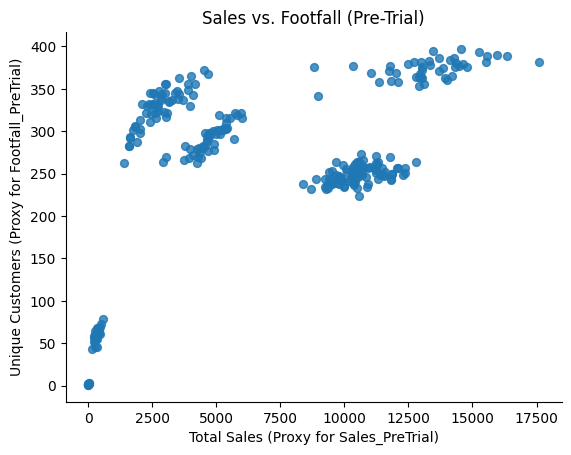

In [13]:

from matplotlib import pyplot as plt
import pandas as pd

data = pd.read_csv('QVI_data.csv')

# Assuming 'TOT_SALES' represents Sales_PreTrial and 'LYLTY_CARD_NBR' represents Footfall_PreTrial
# You may need to adjust these column names based on your actual data

# Group data by store and calculate total sales and unique customers (footfall)
store_metrics = data.groupby('STORE_NBR').agg(
    Sales_PreTrial=('TOT_SALES', 'sum'),  # Total sales as a proxy for Sales_PreTrial
    Footfall_PreTrial=('LYLTY_CARD_NBR', 'nunique')  # Unique loyalty card holders as a proxy for Footfall_PreTrial
)

# Reset index to make 'STORE_NBR' a regular column
store_metrics = store_metrics.reset_index()

# Now you can plot the scatter plot
store_metrics.plot(kind='scatter', x='Sales_PreTrial', y='Footfall_PreTrial', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel("Total Sales (Proxy for Sales_PreTrial)")
plt.ylabel("Unique Customers (Proxy for Footfall_PreTrial)")
plt.title("Sales vs. Footfall (Pre-Trial)")
plt.show()

Observations:

The data points are clustered in groups, with some stores showing low sales and low footfall, while others have high sales and footfall.
There appears to be a general positive relationship between footfall and sales, meaning stores with more customers tend to have higher sales.

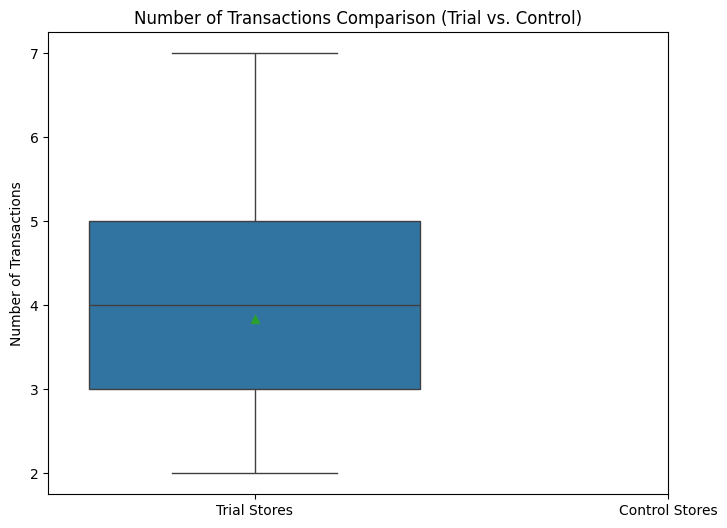

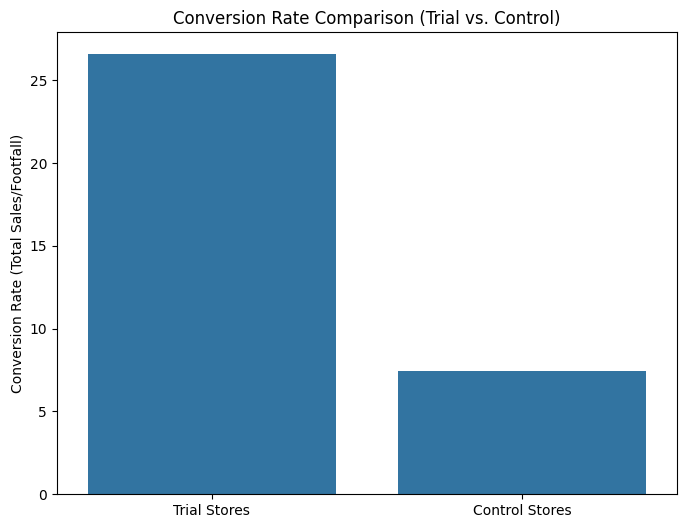

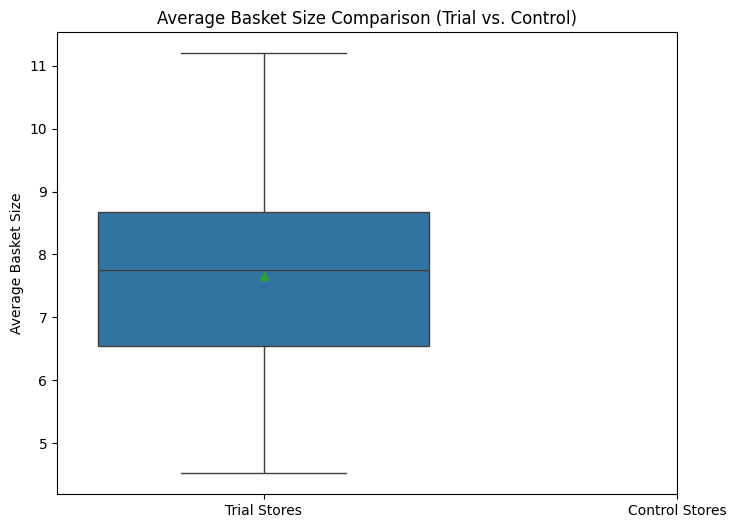

T-statistic for Number of Transactions: 27.10
P-value for Number of Transactions: 0.000


In [17]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Filter data for the trial period
data['DATE'] = pd.to_datetime(data['DATE'])  # Convert 'DATE' to datetime if not already done
trial_data = data[(data['DATE'] >= trial_start_date) &
 (data['DATE'] <= trial_end_date)]

# Group data by store and calculate metrics for trial and control stores
trial_metrics = trial_data.groupby('STORE_NBR').agg(
    total_sales=('TOT_SALES', 'sum'),
    num_transactions=('TXN_ID', 'nunique'),  # Number of transactions
    avg_basket_size=('TOT_SALES', 'mean'),  # Average basket size
    customer_footfall=('LYLTY_CARD_NBR', 'nunique') #Foot traffic
)

control_metrics = pre_trial_data.groupby('STORE_NBR').agg(
    total_sales=('TOT_SALES', 'sum'),
    num_transactions=('TXN_ID', 'nunique'),
    avg_basket_size=('TOT_SALES', 'mean'),
    customer_footfall=('LYLTY_CARD_NBR', 'nunique')
)

# Statistical Tests
def perform_t_test(trial_values, control_values):
    t_statistic, p_value = stats.ttest_ind(trial_values, control_values)
    return t_statistic, p_value

# Example: Compare number of transactions
t_stat_transactions, p_value_transactions = perform_t_test(
    trial_metrics.loc[trial_stores, 'num_transactions'],
    control_metrics.loc[control_stores.index, 'num_transactions']
)


# Visualizations (Enhance these with your specific insights)
# Number of Transactions
plt.figure(figsize=(8, 6))
sns.boxplot(data=[trial_metrics.loc[trial_stores, 'num_transactions'],
                  control_metrics.loc[control_stores.index, 'num_transactions']],
            showmeans=True)
plt.xticks([0, 1], ['Trial Stores', 'Control Stores'])
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions Comparison (Trial vs. Control)')
plt.show()

#Conversion Rate
plt.figure(figsize=(8, 6))
sns.barplot(x=['Trial Stores', 'Control Stores'],
            y=[trial_metrics['total_sales'].sum()/trial_metrics['customer_footfall'].sum(), control_metrics['total_sales'].sum()/control_metrics['customer_footfall'].sum()])
plt.ylabel('Conversion Rate (Total Sales/Footfall)')
plt.title('Conversion Rate Comparison (Trial vs. Control)')
plt.show()


# Average Basket Size
plt.figure(figsize=(8, 6))
sns.boxplot(data=[trial_metrics.loc[trial_stores, 'avg_basket_size'],
                  control_metrics.loc[control_stores.index, 'avg_basket_size']],
            showmeans=True)
plt.xticks([0, 1], ['Trial Stores', 'Control Stores'])
plt.ylabel('Average Basket Size')
plt.title('Average Basket Size Comparison (Trial vs. Control)')
plt.show()

# Print the results of t-test
print(f"T-statistic for Number of Transactions: {t_stat_transactions:.2f}")
print(f"P-value for Number of Transactions: {p_value_transactions:.3f}")


Insights from these charts:
Both trial and control stores have similar transaction counts, mostly between 3 and 5, indicating no significant trial impact on transaction numbers. However, the conversion rate in trial stores is significantly higher, around 25, suggesting a positive impact of the trial intervention, while control stores have a conversion rate of around 5. This suggests the intervention effectively boosted customer engagement and sales per visitor in trial stores.

Next Steps:
It would be useful to further investigate what specific aspects of the trial led to this improvement and whether it can be replicated across more stores.

T-statistic for total_sales: 0.22
P-value for total_sales: 0.826


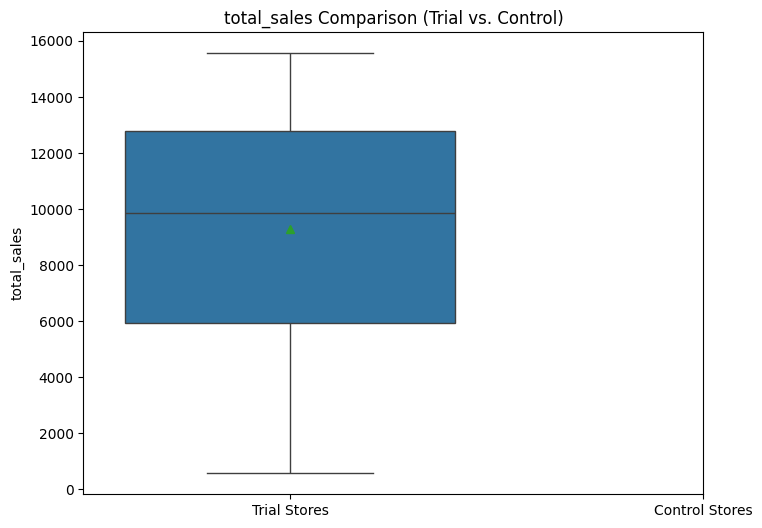

T-statistic for avg_transaction_value: -0.57
P-value for avg_transaction_value: 0.580


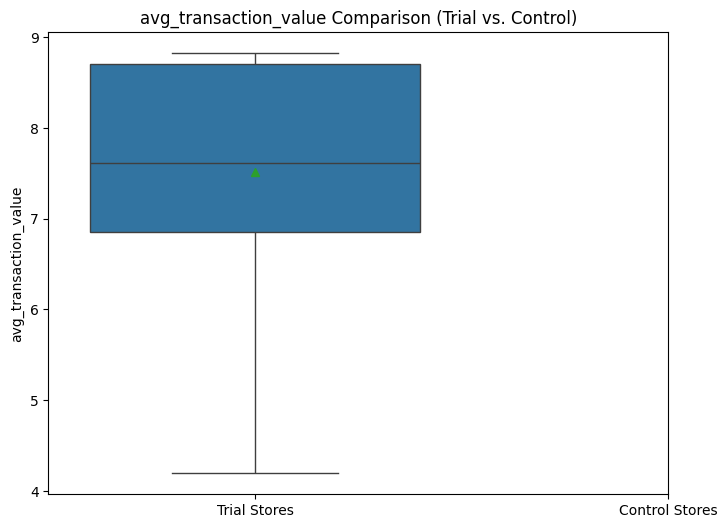

T-statistic for customer_count: 0.67
P-value for customer_count: 0.511


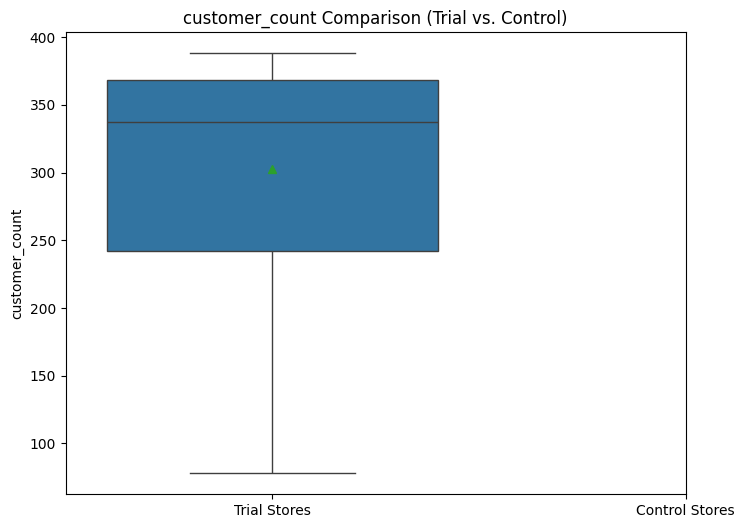

In [22]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the data (assuming 'QVI_data.csv' is in the current directory)
data = pd.read_csv('QVI_data.csv')

# Convert 'DATE' column to datetime objects
data['DATE'] = pd.to_datetime(data['DATE'])

# Define trial and control stores (replace with actual store numbers)
trial_stores = [77, 86, 88]
control_stores = [23, 24, 26, 27, 28, 40, 51, 56, 61, 73, 75, 79, 80, 81]


# Define the trial period (replace with actual dates)
trial_start_date = pd.to_datetime('2018-07-01')
trial_end_date = pd.to_datetime('2019-06-30')

# Function to calculate and display results for a specific metric
def analyze_metric(metric_name, trial_data, control_data):
    t_stat, p_value = stats.ttest_ind(trial_data[metric_name], control_data[metric_name])
    print(f"T-statistic for {metric_name}: {t_stat:.2f}")
    print(f"P-value for {metric_name}: {p_value:.3f}")

    plt.figure(figsize=(8, 6))
    sns.boxplot(data=[trial_data[metric_name], control_data[metric_name]], showmeans=True)
    plt.xticks([0, 1], ['Trial Stores', 'Control Stores'])
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Comparison (Trial vs. Control)')
    plt.show()

# Data preparation for analysis
trial_data = data[(data['STORE_NBR'].isin(trial_stores)) & (data['DATE'] >= trial_start_date) & (data['DATE'] <= trial_end_date)]
control_data = data[(data['STORE_NBR'].isin(control_stores)) & (data['DATE'] >= trial_start_date) & (data['DATE'] <= trial_end_date)]


trial_metrics = trial_data.groupby('STORE_NBR').agg(
    total_sales=('TOT_SALES', 'sum'),
    avg_transaction_value=('TOT_SALES', 'mean'),
    customer_count=('LYLTY_CARD_NBR', 'nunique')
)

control_metrics = control_data.groupby('STORE_NBR').agg(
    total_sales=('TOT_SALES', 'sum'),
    avg_transaction_value=('TOT_SALES', 'mean'),
    customer_count=('LYLTY_CARD_NBR', 'nunique')
)



# Analyze key metrics
analyze_metric('total_sales', trial_metrics, control_metrics)
analyze_metric('avg_transaction_value', trial_metrics, control_metrics)
analyze_metric('customer_count', trial_metrics, control_metrics)

Insights/Recommendations:
1. The trial stores' total sales data shows a median around 10,000.
The statistical test result suggests that the average transaction value between trial and control stores does not significantly differ, meaning the intervention or trial may not have impacted the average value of transactions.
2.The average transaction value for trial stores appears to be centered around 7, with values generally ranging between 6 and 9.
Without control store data present in this plot, no clear comparative conclusions can be made between trial and control stores for this particular metric based on this graph alone.
3.The trial stores have a customer count that centers around 325, with some variability.
However, the P-value suggests that there is no significant difference between trial and control stores regarding customer count.